Notes for Jacopo:


<br>
This EDAA  is for Walter, in order to find togheter a mattern or a signal that needs to be investigated<br>


In [3]:
kernel='j'

In [4]:
if kernel!='Y':
  !git clone https://github.com/nudojacopo/thesis.git
  from google.colab import drive
  drive.mount('/content/drive')
  source_data='/content/drive/MyDrive/thesis/data/voat/voat_labeled_data_unified.parquet'
  root='/content/'
else:
  source_data='/Users/jacoponudo/Documents/thesis/data/voat/voat_labeled_data_unified.parquet'
  root='/Users/jacoponudo/Documents/'
output=root+'src/HWK/output'
output_threads=root+'src/HWK/output/temporary'
import sys
module_path = root+'thesis/src/EDA'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from EDA_package.function import *
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

Cloning into 'thesis'...
remote: Enumerating objects: 449, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 449 (delta 70), reused 53 (delta 22), pack-reused 320
Receiving objects: 100% (449/449), 26.53 MiB | 17.19 MiB/s, done.
Resolving deltas: 100% (200/200), done.
Mounted at /content/drive


In [5]:
import sys
import os
import numpy as np
module_path = '/Users/jacoponudo/Documents/thesis/src/EDA'
sys.path.append(module_path)
from EDA_package.function import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from scipy.stats import chi2_contingency

In [6]:
data=pd.read_csv('/content/drive/MyDrive/thesis/data/voat/voat_processed.csv',dtype={
        'comment_id': 'int',
        'sequential_number_of_comment_by_user_in_thread': 'int',
        'number_of_comments_by_user_in_thread': 'int',
        'root_submission': 'int'})

# IAT Valley


*Escludiamo le interazione con meno di 3 commenti, calcoliamo la posizione rispetto all'inizio e la fine della conversazione ∈ [0,1]*

In [216]:
data=data[data['number_of_comments_by_user_in_thread']>5].copy()
data['position_user_thread']=data['sequential_number_of_comment_by_user_in_thread']/data['number_of_comments_by_user_in_thread']

*L'IAT non è omogeneo nella conversazone.
Notiamo che l'inter arrival time tende a crescere nella fase finale della conversazione, l'utente si stufa, risponde sempre meno prontamente, fino a uscire.*

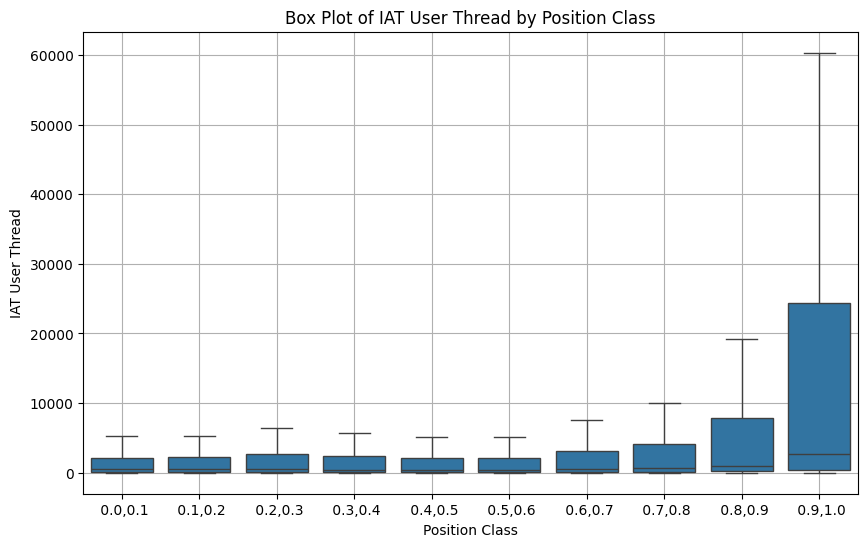

In [8]:
number_of_classes=10
data['position_class'] = pd.cut(data['position_user_thread'], bins=number_of_classes, labels=False)

plt.figure(figsize=(10, 6))
sns.boxplot(x='position_class', y='IAT_user_thread', data=data,showfliers=False)
plt.title('Box Plot of IAT User Thread by Position Class')
plt.xlabel('Position Class')
plt.ylabel('IAT User Thread')
plt.xticks(ticks=range(number_of_classes), labels=[f' {i/number_of_classes},{(i+1)/number_of_classes}' for i in range(number_of_classes)])
plt.grid(True)
plt.show()

*Osserviamo come se la fase finale della conversazione risulta piu rilassata, con ritmi piu flebili, la conversazione tende ad essere meno tossica.*


<ipython-input-9-cfebcf1bcc51>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='IAT_increases', y='is_toxic', data=merged_df,showfliers=False, palette='Set2')


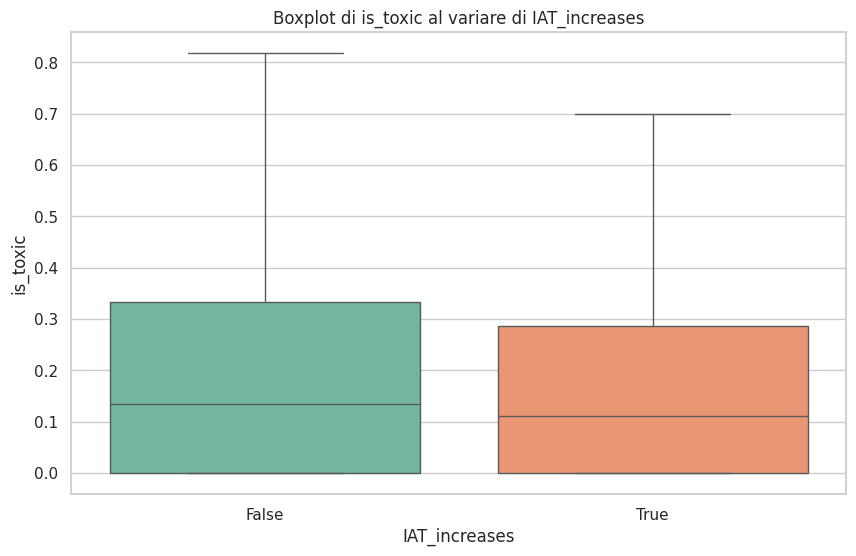

In [9]:
# Trova l'IAT mediana e finale di ogni conversazione per ogni utente
mean_IAT = data.groupby(['user', 'root_submission'])['IAT_user_thread'].median().reset_index()
final_IAT = data[data['position_class'].isin([number_of_classes-1])].groupby(['user', 'root_submission'])['IAT_user_thread'].first().reset_index()
semifinal_IAT = data[data['position_class'].isin([number_of_classes-2])].groupby(['user', 'root_submission'])['IAT_user_thread'].first().reset_index()

# Unisci i due DataFrame sulla chiave 'user' e 'root_submission'
merged_df = mean_IAT.merge(final_IAT, on=['user', 'root_submission'], suffixes=('_median', '_final'))
merged_df = merged_df.merge(semifinal_IAT, on=['user', 'root_submission'], suffixes=('', '_semifinal'))

merged_df['IAT_increases'] = (merged_df['IAT_user_thread_final'] > 1.5*(merged_df['IAT_user_thread_median'])) & ( merged_df['IAT_user_thread'] > 1.2*(merged_df['IAT_user_thread_median']))


data['is_toxic']=data['toxicity_score']>0.6
toxicity=data.groupby(['user','root_submission'])['is_toxic'].mean()

merged_df=merged_df.merge(toxicity,on=['user', 'root_submission'])

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(x='IAT_increases', y='is_toxic', data=merged_df,showfliers=False, palette='Set2')
plt.title('Boxplot di is_toxic al variare di IAT_increases')
plt.xlabel('IAT_increases')
plt.ylabel('is_toxic')
plt.show()

Il valley pattern, ultimi commenti meno vivaci diopende anche dall'utente? Si tdistribuiscono in maniera omogenea?

# Quanti siamo e quanto Parlo

Meno è affollata la conversazione nell'intorno di un commento piu lunga sarà l'interazione user-thread a cui il commeento appartiene.

In [93]:
from datetime import datetime, timedelta



df=data
# Convertire la colonna 'created_at' in formato datetime
df['created_at'] = pd.to_datetime(df['created_at'])
results = []


for i,row in tqdm(df.iterrows(),total=len(df)):
  # Selezionare una riga
  riga_selezionata = row

  # Estrarre il valore di 'created_at'
  valore_created_at = riga_selezionata['created_at']

  # Calcolare l'intervallo di tempo di 10 minuti
  delta_tempo = timedelta(minutes=10)

  # Calcolare l'intervallo di tempo entro 10 minuti in più e in meno rispetto a 'created_at'
  time_range_start = ((valore_created_at - delta_tempo))
  time_range_end =str( (valore_created_at + delta_tempo))

  # Creare una maschera booleana per filtrare tra le due date
  mask = (df['created_at'] >= time_range_start) & (df['created_at'] <= time_range_end)

  filtered_df = df.loc[mask]

  y=filtered_df.user.nunique()
  x=riga_selezionata.number_of_comments_by_user_in_thread
  results.append({'x': x, 'y': y})

# Convertire la lista dei risultati in un DataFrame
results_df = pd.DataFrame(results)


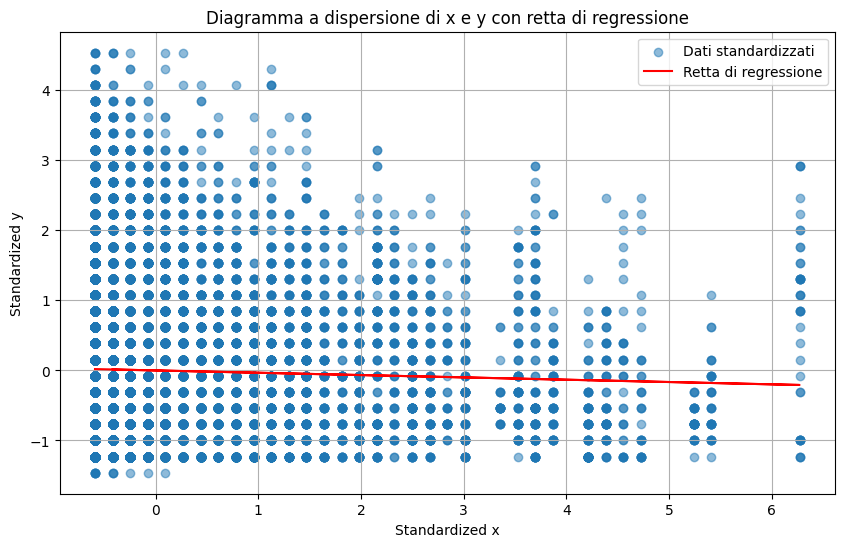

In [96]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
# Standardizzazione dei dati
scaler = StandardScaler()
results_df[['x', 'y']] = scaler.fit_transform(results_df[['x', 'y']])

# Creazione del modello di regressione lineare
model = LinearRegression()
model.fit(results_df[['x']], results_df['y'])

# Previsione dei valori di y
results_df['y_pred'] = model.predict(results_df[['x']])

# Tracciamento del diagramma a dispersione con la retta di regressione
plt.figure(figsize=(10, 6))
plt.scatter(results_df['x'], results_df['y'], alpha=0.5, label='Dati standardizzati')
plt.plot(results_df['x'], results_df['y_pred'], color='red', label='Retta di regressione')
plt.title('Diagramma a dispersione di x e y con retta di regressione')
plt.xlabel('Standardized x')
plt.ylabel('Standardized y')
plt.legend()
plt.grid(True)
plt.show()

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

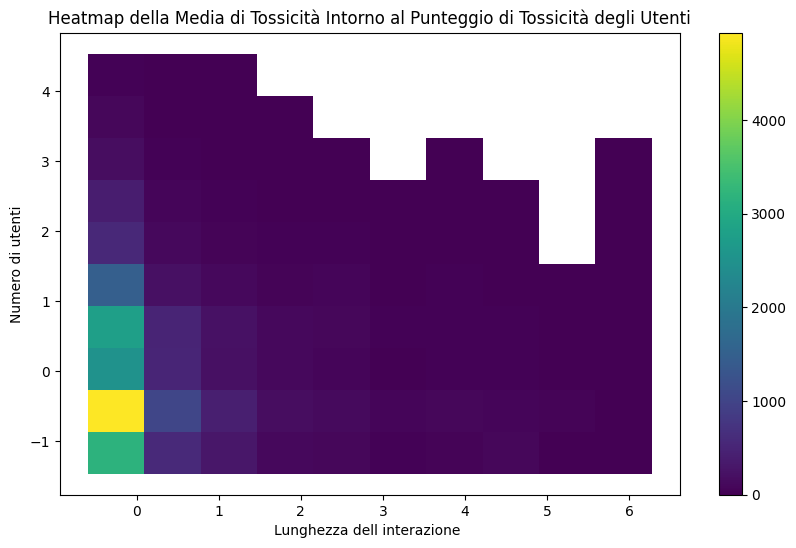

In [97]:
plt.figure(figsize=(10, 6))
sns.histplot(data=results_df, x='x', y='y', bins=10, cmap='viridis', cbar=True)
plt.title('Heatmap della Media di Tossicità Intorno al Punteggio di Tossicità degli Utenti')
plt.xlabel('Lunghezza dell interazione ')
plt.ylabel('Numero di utenti')
plt.colorbar(label='Frequenza')
plt.show()

# Toxicità nell'intorno

Analizziamo se un commento tossico, nel suo intorno è circondato da commenti tossici. I seguenti risultati sono ottenuti usando un intorno di raggio 2. Mostrano che esiste una correlazione tra il livello di tossicità e l'intorno temporale di una conversazione.
Questo però non tiene conto che in alcune piattaforme le conversazioni si ramificano.

100%|██████████| 381535/381535 [23:51<00:00, 266.60it/s]


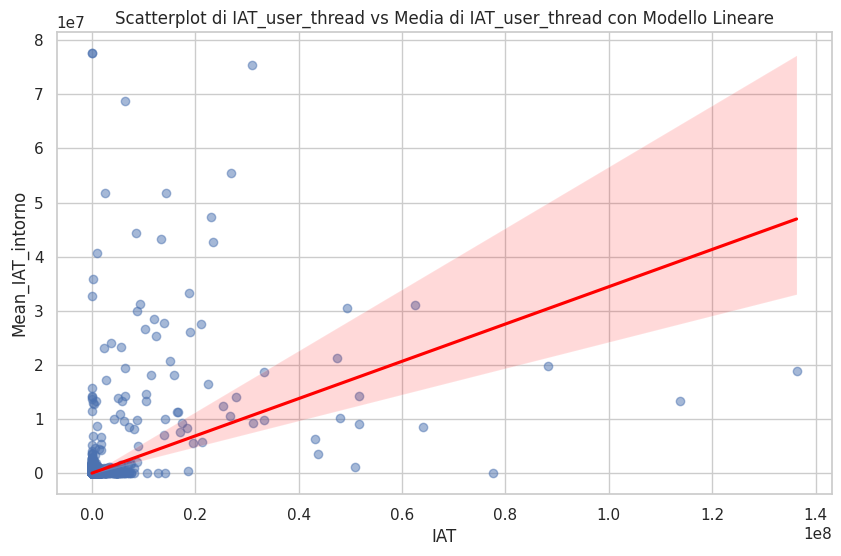

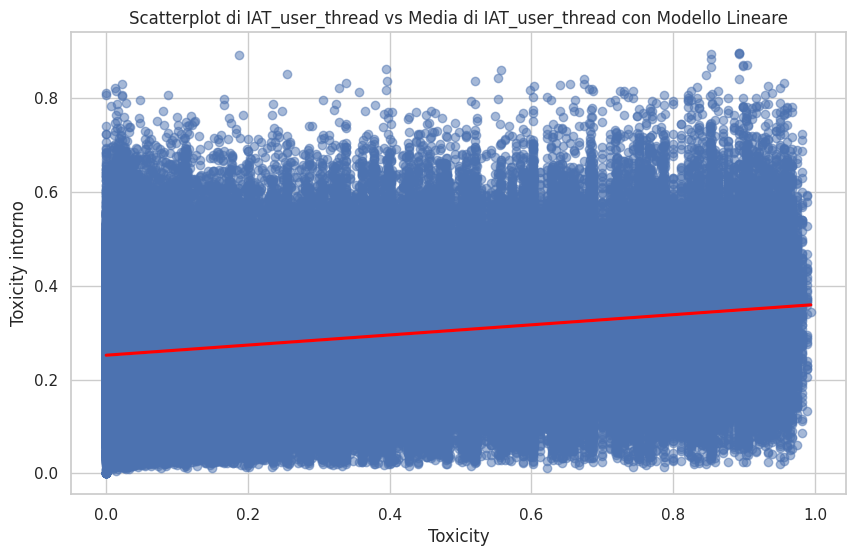

In [208]:
data_sorted = data.sort_values(by='created_at').reset_index(drop=True)
#data_sorted=data_sorted[data_sorted['sequential_number_of_comment_by_user_in_thread']>1]



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Creazione di DataFrame vuoti per x e y
x = []
y = []
z = []
j = []


r=5

# Iterazione sul DataFrame data_sorted
for i, row in tqdm(data_sorted.iterrows(),total=len(data_sorted)):
    iat = row['toxicity_score']
    created_at = row['created_at']

    df=data_sorted[data_sorted['root_submission']==row['root_submission']].reset_index()

    i=(df['created_at'] == created_at).idxmax()
    mean_iat = np.mean(df.loc[i - r:i + r+1, 'toxicity_score'].drop(i))
    mean_j = np.mean(df.loc[i - r:i + r+1, 'IAT_user_thread'].drop(i))


    # Aggiungi i valori a x e y solo se non sono NaN o non numerici
    if pd.notna(iat) and pd.notna(mean_iat) and np.isfinite(mean_iat):
        x.append(iat)
        y.append(mean_iat)
        z.append(row['IAT_user_thread'])
        j.append(mean_j)

scatter_df = pd.DataFrame({'IAT': z, 'Mean_IAT_intorno': j,'Toxicity': x,'Toxicity intorno':y})
scatter_df
# Creazione dello scatterplot con il modello lineare
plt.figure(figsize=(10, 6))
sns.regplot(x='IAT', y='Mean_IAT_intorno', data=scatter_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Scatterplot di IAT_user_thread vs Media di IAT_user_thread con Modello Lineare')
plt.show()

# Creazione dello scatterplot con il modello lineare
plt.figure(figsize=(10, 6))
sns.regplot(x='Toxicity', y='Toxicity intorno', data=scatter_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Scatterplot di IAT_user_thread vs Media di IAT_user_thread con Modello Lineare')
plt.show()


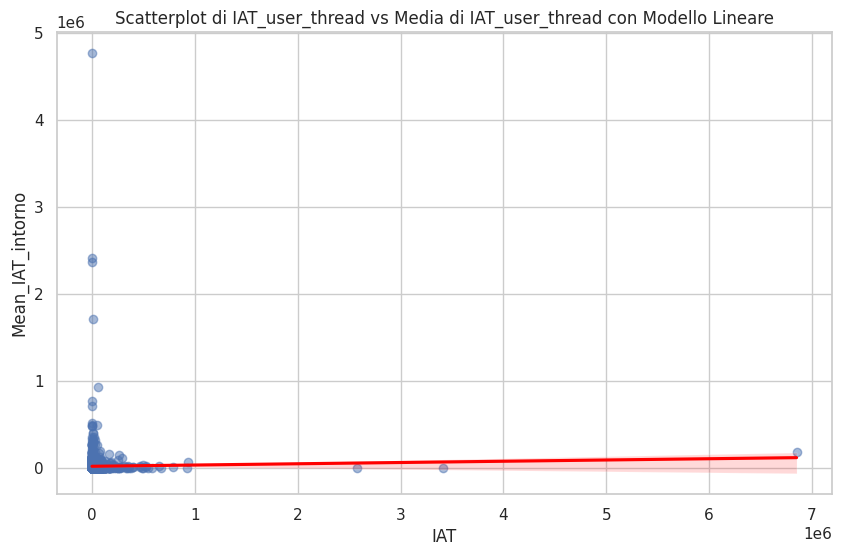

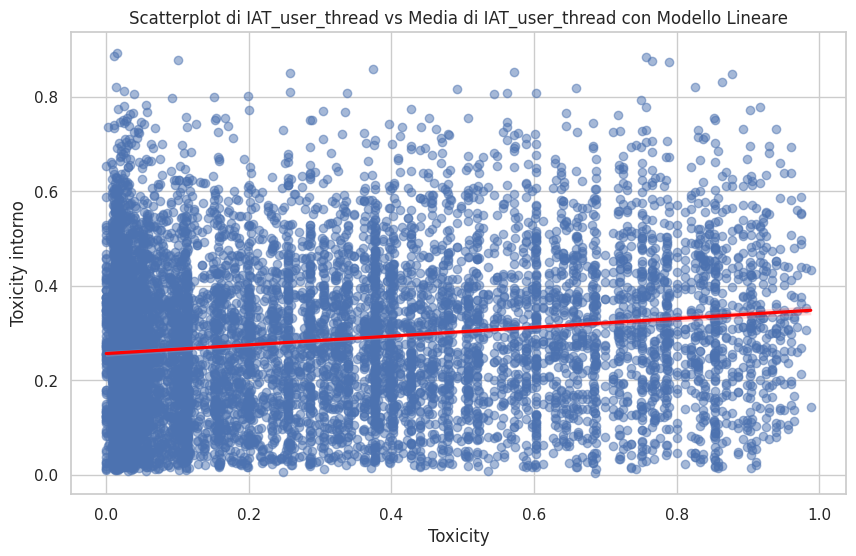

In [213]:
data_sorted = data.sort_values(by='created_at').reset_index(drop=True)
#data_sorted=data_sorted[data_sorted['sequential_number_of_comment_by_user_in_thread']>1]
data_sorted=data_sorted.sample(100000)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Creazione di DataFrame vuoti per x e y
x = []
y = []
z = []
j = []


r=2

# Iterazione sul DataFrame data_sorted
for i, row in tqdm(data_sorted.iterrows(),total=len(data_sorted)):
    iat = row['toxicity_score']
    created_at = row['created_at']

    df=data_sorted[data_sorted['root_submission']==row['root_submission']].reset_index()

    i=(df['created_at'] == created_at).idxmax()
    mean_iat = np.mean(df.loc[i - r:i + r+1, 'toxicity_score'].drop(i))
    mean_j = np.mean(df.loc[i - r:i + r+1, 'IAT_user_thread'].drop(i))


    # Aggiungi i valori a x e y solo se non sono NaN o non numerici
    if pd.notna(iat) and pd.notna(mean_iat) and np.isfinite(mean_iat):
        x.append(iat)
        y.append(mean_iat)
        z.append(row['IAT_user_thread'])
        j.append(mean_j)

scatter_df = pd.DataFrame({'IAT': z, 'Mean_IAT_intorno': j,'Toxicity': x,'Toxicity intorno':y})
scatter_df

# Creazione dello scatterplot con il modello lineare
plt.figure(figsize=(10, 6))
sns.regplot(x='Toxicity', y='Toxicity intorno', data=scatter_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Scatterplot di IAT_user_thread vs Media di IAT_user_thread con Modello Lineare')
plt.show()


In [214]:
data.columns
plt.figure(figsize=(10, 6))
sns.histplot(data=scatter_df, x='Toxicity', y='Toxicity intorno', bins=10, cmap='viridis', cbar=True)
plt.title('Heatmap della Media di Tossicità Intorno al Punteggio di Tossicità degli Utenti')
plt.xlabel('IAT_user_thread')
plt.ylabel('Media di IAT_user_thread')
plt.colorbar(label='Frequenza')
plt.show()

Index(['comment_id', 'text', 'video_id', 'user', 'upvotes', 'downvotes',
       'depth', 'root_submission', 'topic', 'toxicity_score', 'created_at',
       'social', 'percentile',
       'sequential_number_of_comment_by_user_in_thread',
       'number_of_comments_by_user_in_thread', 'thread_birth',
       'temporal_distance_birth_h', 'thread_lifetime_h', 'number_of_users',
       'unique_words_count', 'number_of_comments', 'language',
       'unique_word_user', 'temporal_distance_from_previous_comment_h',
       'IAT_user', 'IAT_user_thread', 'IAT_thread'],
      dtype='object')

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

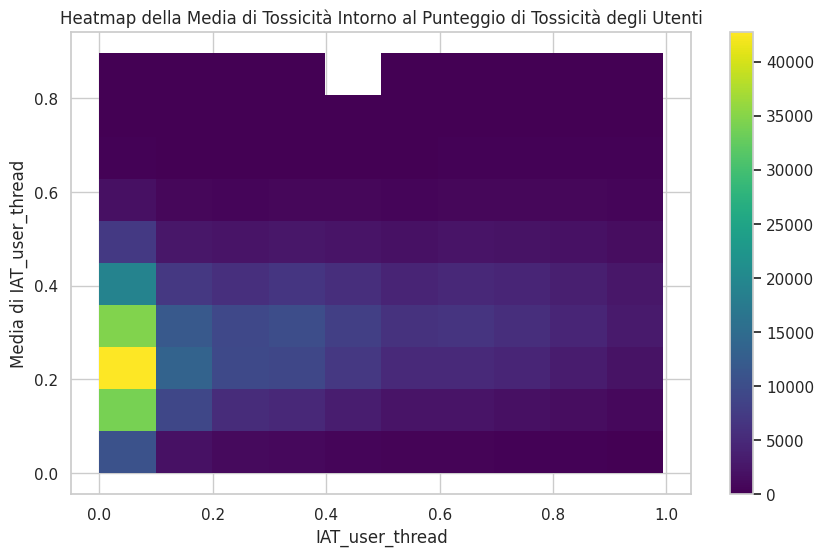

In [211]:
# Creazione del heatmap
scatter_df['Toxicity intorno'] = pd.to_numeric(scatter_df['Toxicity intorno'], errors='coerce')
scatter_df = scatter_df.dropna(subset=['Toxicity intorno'])
plt.figure(figsize=(10, 6))
sns.histplot(data=scatter_df, x='Toxicity', y='Toxicity intorno', bins=10, cmap='viridis', cbar=True)
plt.title('Heatmap della Media di Tossicità Intorno al Punteggio di Tossicità degli Utenti')
plt.xlabel('IAT_user_thread')
plt.ylabel('Media di IAT_user_thread')
plt.colorbar(label='Frequenza')
plt.show()


Per avere un idea piu chiara utilizziamo una griglia di valori di intorno e massimiziamo la correlazione della nuvola di punti.